In [1]:
from time import time

start = time()

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03ff\u1f00-\u1fff]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"
            else:
                for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                    match = re.search(regex_pattern, text)
                    if match:
                        pred = lang_code
                        break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


### Greek-English identification dataset

https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [8]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(15000)
others_df.labels = "other"
others_df

,labels,text
49980,other,Ataque suicida do Iémen mata 7 soldados: oficiais
46937,other,"на и punchestown racecourses са тук , а национ..."
42332,other,Cung điện dolma-Bahce ( dolmabahce saraye ; do...
81923,other,चेक रिपब्लिक के लिए Atta की यात्रा हेतु ibid प...
80841,other,واضح طور پر، AICPA کی قدر بڑھانے اور تجارت پر ...
...,...,...
11586,other,लेकिन आप इस देश और उसके महान कॉर ् पोरेशन को इ...
14982,other,3mmの段差で根元がグラつき、最終的に根元からパックリ割れました。
13868,other,"""Przyjaciele Syrii"" w Doha rozmawiają o uzbroj..."
33077,other,اس کے سیروشکار ( سیروشکار ) اور سیروشکار ( شاہ...


In [9]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
23995,other,लेकिन आप इस देश और उसके महान कॉर ् पोरेशन को इ...
23996,other,3mmの段差で根元がグラつき、最終的に根元からパックリ割れました。
23997,other,"""Przyjaciele Syrii"" w Doha rozmawiają o uzbroj..."
23998,other,اس کے سیروشکار ( سیروشکار ) اور سیروشکار ( شاہ...


### Greek-Greeklish identification dataset

In [10]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [11]:
from src.crawling import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.99it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.66it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.50it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.22it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]


Processing page 7 of 8...


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  5.14it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.20it/s]


Processing page 8 of 8...


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:01<00:00,  5.41it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.75it/s]


In [12]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

415

In [13]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [14]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [15]:
warmane_df = warmane_df[~empty_contents]

In [16]:
from src.crawling import ChromeDriverManager, jupyter_options


ChromeDriverManager.set_options(jupyter_options())

In [17]:
from tasks.youtube import extract_search_results, extract_comments, scrape_youtube


greek_yt_urls = ["https://www.youtube.com/watch?v=4Y2gxkqbsbA", 
       "https://www.youtube.com/watch?v=31LcJ9gqQvA",
       "https://www.youtube.com/watch?v=1cZXAQ1JEJo",
       "https://www.youtube.com/watch?v=x7lnS6jMS64",
       "https://www.youtube.com/watch?v=ImilczGN-00"]
scrape_results = []

for url in tqdm(greek_yt_urls):
    scrape_results.append(scrape_youtube(ChromeDriverManager.get(), url, max_scrolls=10, verbose=False))

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Creating new driver...
New driver online.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:28<00:00, 17.69s/it]


In [18]:
from tasks.youtube import extract_comments


all_comments = []
for result in scrape_results:
    comments, _ = extract_comments(result)
    all_comments += comments

all_comments = pd.Series(all_comments)

In [19]:
greeklish_series = pd.concat([warmane_df.contents, all_comments])
greeklish_series

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
                                 ...                        
812                                        Gianni παίξε Pubg
813                                                    Πρώτη
814                                                    First
815                                             First of all
816                                                   Πρώτος
Length: 1225, dtype: object

In [20]:
conditions = (greeklish_series.apply(lambda x: len(x) != 0)) & \
                (greeklish_series.apply(lambda x: "RRR" not in x)) & \
                (greeklish_series.apply(lambda x: "PPP" not in x)) & \
                (greeklish_series.apply(lambda x: "First" not in x))
cleared_greeklish_series = greeklish_series[conditions]
cleared_greeklish_series

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
                                 ...                        
810                                               Πρώτο like
811                                                   Πρώτος
812                                        Gianni παίξε Pubg
813                                                    Πρώτη
816                                                   Πρώτος
Length: 1197, dtype: object

In [21]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(cleared_greeklish_series)

In [22]:
cleared_greeklish_series[preds=="greeklish"]

Series([], dtype: object)

In [23]:
cleared_greeklish_series[preds=="en"]

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
796                                         Epitelous amogus
801        Ante Pali me ta atoma pou einai first.... Mhn ...
803                                                      Lol
804                                             na xanapexis
809                                                     Hafa
Length: 471, dtype: object

In [24]:
cleared_greeklish_series[preds=="el"]

2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
810                                               Πρώτο like
811                                                   Πρώτος
812                                        Gianni παίξε Pubg
813                                                    Πρώτη
816                                                   Πρώτος
Length: 718, dtype: object

In [25]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": cleared_greeklish_series})
gold2_df

,labels,text
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
810,el,Πρώτο like
811,el,Πρώτος
812,el,Gianni παίξε Pubg
813,el,Πρώτη


In [26]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
810,el,Πρώτο like
811,el,Πρώτος
812,el,Gianni παίξε Pubg
813,el,Πρώτη


In [27]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file, encoding = 'utf8')
    print(f"File saved successfully as {file}")

In [28]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

In [29]:
from tasks.youtube import extract_search_results, extract_comments


# "greek songs" search in Greek
song_search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(ChromeDriverManager.get(), song_search_url, max_scrolls=5, verbose=True)
results_search_song = extract_search_results(search_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [30]:
gaming_search_url = "https://www.youtube.com/results?search_query=greek+fortnite"
gaming_soup = scrape_youtube(ChromeDriverManager.get(), gaming_search_url, max_scrolls=5, verbose=True)
results_search_gaming = extract_search_results(gaming_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [31]:
results_df = pd.DataFrame({"title": results_search_song[0] + results_search_gaming[0],
                           "link":  results_search_song[1] + results_search_gaming[1],
                          "source": np.array(len(results_search_song[0])*["song"] + len(results_search_gaming[0])*["gaming"]) })
results_df

,title,link,source
0,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...,song
1,"\n\nΠου 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημέ...",/watch?v=OdX0y96UPEA&pp=ygUjzrXOu867zrfOvc65zr...,song
2,\n\nGreek Mix Songs | Love Hits Non-Stop | Gal...,/watch?v=lcvlYbyAhpI&pp=ygUjzrXOu867zrfOvc65zr...,song
3,\n\nΌμορφα ελληνικά τραγούδια\n,/watch?v=UIfND1RykJc&pp=ygUjzrXOu867zrfOvc65zr...,song
4,\n\nΓΙΝΑΜΕ ΣΟΥΠΕΡ ΚΑΚΟΙ ΗΡΩΕΣ ΓΙΑ 24 ΩΡΕΣ!\n,/watch?v=tlpTl7miJwM&pp=ygUjzrXOu867zrfOvc65zr...,song
...,...,...,...
275,\n\nΣυμβουλές και Κόλπα για να γινεις Καλύτερο...,/watch?v=bTr9ztR9CUE&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming
276,\n\nΜΟΥ ΕΚΡΥΨΕ ΤΟ ΛΑΠΤΟΠ ΓΙΑ ΝΑ ΜΗ ΠΑΙΖΩ FORTN...,/watch?v=Cg_QnSO0wQU&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming
277,\n\nΠως να παίζεις Claw στο Fortnite!\n,/watch?v=DnoU4PgA_OM&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming
278,\n\n1 VS 1 CHALLENGE ΜΕ ΤΗΝ ΚΩΝΣΤΑΝΤΙΝΑ ΑΠΟ Pl...,/watch?v=64NObRZWREA&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming


In [32]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link,source
0,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...,song
1,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song
2,Greek Mix Songs | Love Hits Non-Stop | Galaxy ...,https://www.youtube.com/watch?v=lcvlYbyAhpI&pp...,song
3,Όμορφα ελληνικά τραγούδια,https://www.youtube.com/watch?v=UIfND1RykJc&pp...,song
4,ΓΙΝΑΜΕ ΣΟΥΠΕΡ ΚΑΚΟΙ ΗΡΩΕΣ ΓΙΑ 24 ΩΡΕΣ!,https://www.youtube.com/watch?v=tlpTl7miJwM&pp...,song
...,...,...,...
275,Συμβουλές και Κόλπα για να γινεις Καλύτερος πα...,https://www.youtube.com/watch?v=bTr9ztR9CUE&pp...,gaming
276,ΜΟΥ ΕΚΡΥΨΕ ΤΟ ΛΑΠΤΟΠ ΓΙΑ ΝΑ ΜΗ ΠΑΙΖΩ FORTNITE!,https://www.youtube.com/watch?v=Cg_QnSO0wQU&pp...,gaming
277,Πως να παίζεις Claw στο Fortnite!,https://www.youtube.com/watch?v=DnoU4PgA_OM&pp...,gaming
278,1 VS 1 CHALLENGE ΜΕ ΤΗΝ ΚΩΝΣΤΑΝΤΙΝΑ ΑΠΟ PlaySt...,https://www.youtube.com/watch?v=64NObRZWREA&pp...,gaming


In [33]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link,source
1,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song
3,Όμορφα ελληνικά τραγούδια,https://www.youtube.com/watch?v=UIfND1RykJc&pp...,song
4,ΓΙΝΑΜΕ ΣΟΥΠΕΡ ΚΑΚΟΙ ΗΡΩΕΣ ΓΙΑ 24 ΩΡΕΣ!,https://www.youtube.com/watch?v=tlpTl7miJwM&pp...,song
5,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song
10,Κανείς Εδώ Δεν Τραγουδά - Kaneis Edw Den Trago...,https://www.youtube.com/watch?v=SlJ9x3A0NmU&pp...,song
...,...,...,...
275,Συμβουλές και Κόλπα για να γινεις Καλύτερος πα...,https://www.youtube.com/watch?v=bTr9ztR9CUE&pp...,gaming
276,ΜΟΥ ΕΚΡΥΨΕ ΤΟ ΛΑΠΤΟΠ ΓΙΑ ΝΑ ΜΗ ΠΑΙΖΩ FORTNITE!,https://www.youtube.com/watch?v=Cg_QnSO0wQU&pp...,gaming
277,Πως να παίζεις Claw στο Fortnite!,https://www.youtube.com/watch?v=DnoU4PgA_OM&pp...,gaming
278,1 VS 1 CHALLENGE ΜΕ ΤΗΝ ΚΩΝΣΤΑΝΤΙΝΑ ΑΠΟ PlaySt...,https://www.youtube.com/watch?v=64NObRZWREA&pp...,gaming


In [34]:
from selenium.common.exceptions import JavascriptException
import bs4


def scrape(urls: list[str]) -> list[tuple[str, bs4.BeautifulSoup]]:
    scrape_results = []
    
    print("Scraping videos...")
    for url in tqdm(urls):
        try:
            scrape_results.append((url, scrape_youtube(ChromeDriverManager.get(), url, max_scrolls=10, scroll_wait_secs=1.3, verbose=False)))
        except JavascriptException:
            continue
        except Exception as e:
            print(e)
            continue  
    return scrape_results


def process_scraped(scrape_results: list[tuple[str, bs4.BeautifulSoup]]) -> pd.DataFrame:
    scraped_urls = []
    comments = []
    dates = []
    
    print("Processing comments...")
    print(type(scrape_results[0]))
    for url, result in tqdm(scrape_results):
        if result is not None:
            new_comments, new_dates = extract_comments(result)
            comments += new_comments
            dates += new_dates
            scraped_urls += ([url] * len(new_comments))
    return pd.DataFrame({"link": scraped_urls, "text": comments, "date": dates})


def filter_comments(df: pd.DataFrame) -> pd.DataFrame:
    preds = greeklish_model.predict(df.text)
    mask = ((preds != "el") & (preds != "greeklish"))
    return comments_df[mask]

In [35]:
crawl_df = pd.read_csv("output/temp.csv", encoding="utf8")
crawl_df.date = pd.to_datetime(crawl_df.date)
crawl_df

,Unnamed: 0,title,link,source,text,date
0,0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,"Great selection, one more time. THANKS!",2023-07-27
1,1,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,NaN,2023-07-27
2,2,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,NaN,2023-09-27
3,3,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,️,2023-07-27
4,4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Încă o zi petrecută cu muzica voastră fantas...,2022-11-27
...,...,...,...,...,...,...
3450,3450,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,Fake,2023-11-18
3451,3451,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,malaka einai gia ton poutso to stisimo tou vinteo,2023-11-23
3452,3452,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,KALITERA,2023-11-19
3453,3453,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,o monos youtuber pou dn exei bgalei pote fake ...,2023-11-18


In [36]:
crawl_df = crawl_df.dropna()
crawl_df = crawl_df[~crawl_df.text.apply(lambda x: len(x.strip())==0)]
crawl_df

,Unnamed: 0,title,link,source,text,date
0,0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,"Great selection, one more time. THANKS!",2023-07-27
3,3,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,️,2023-07-27
4,4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Încă o zi petrecută cu muzica voastră fantas...,2022-11-27
5,5,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,ANTIGUAS CANCIONES DE GRECIA PAIS NATAL DE MIS...,2022-11-27
6,6,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,FelicităriSuperb \nSă fiți mereu bine \nMomen...,2022-11-27
...,...,...,...,...,...,...
3450,3450,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,Fake,2023-11-18
3451,3451,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,malaka einai gia ton poutso to stisimo tou vinteo,2023-11-23
3452,3452,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,KALITERA,2023-11-19
3453,3453,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,o monos youtuber pou dn exei bgalei pote fake ...,2023-11-18


In [37]:
ChromeDriverManager.quit()

In [38]:
csv_output(crawl_df, "temp.csv")

File saved successfully as output\temp.csv


## Language Identification

https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he
https://gking.harvard.edu/files/abs/0s-abs.shtml
https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data


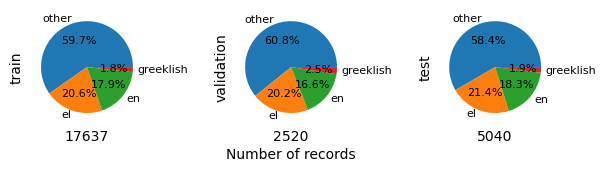

In [39]:
from src.ml import train_test_val_split
import matplotlib.pyplot as plt


data_train, data_val, data_test = train_test_val_split(gold_df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2,
                                                        random_state=42, stratify_col="labels")
# code block from Ioannis Pavlopoulos
axes = pd.DataFrame({"train": data_train.labels.value_counts(),
              "validation": data_val.labels.value_counts(),
              "test": data_test.labels.value_counts()}
            ).plot.pie(subplots=True, 
                       textprops={'fontsize': 8},
                       autopct=f'%1.1f%%', # print percent% results 
                       legend=False)

axes[0].set_xlabel(data_train.shape[0])
axes[1].set_xlabel(data_val.shape[0])
axes[2].set_xlabel(data_test.shape[0])

axes[1].text(0, -2, 'Number of records', ha='center')

plt.tight_layout(pad=2.0)
plt.show()

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_val = vectorizer.transform(data_val.text)
y_val = data_val.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

In [41]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [42]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.18425009397318634
              precision    recall  f1-score   support

          el       0.00      0.00      0.00      1081
          en       0.00      0.00      0.00       920
   greeklish       0.00      0.00      0.00        98
       other       0.58      1.00      0.74      2941

    accuracy                           0.58      5040
   macro avg       0.15      0.25      0.18      5040
weighted avg       0.34      0.58      0.43      5040



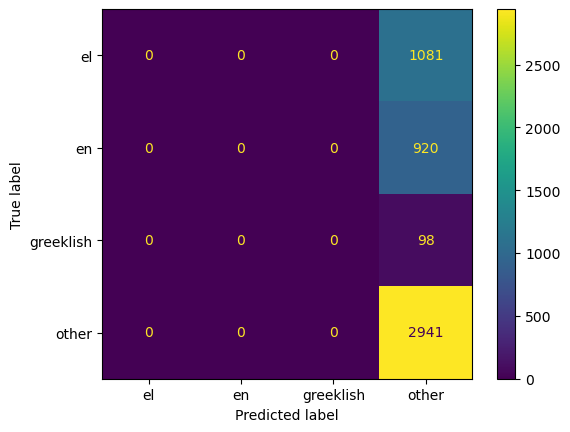

In [43]:
from sklearn.dummy import DummyClassifier, DummyRegressor


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.4604, std: 0.4578


Macro F1: 0.4606684945081718
              precision    recall  f1-score   support

          el       1.00      0.71      0.83      1081
          en       0.32      1.00      0.48       920
   greeklish       0.00      0.00      0.00        98
       other       1.00      0.36      0.53      2941

    accuracy                           0.55      5040
   macro avg       0.58      0.52      0.46      5040
weighted avg       0.85      0.55      0.58      5040



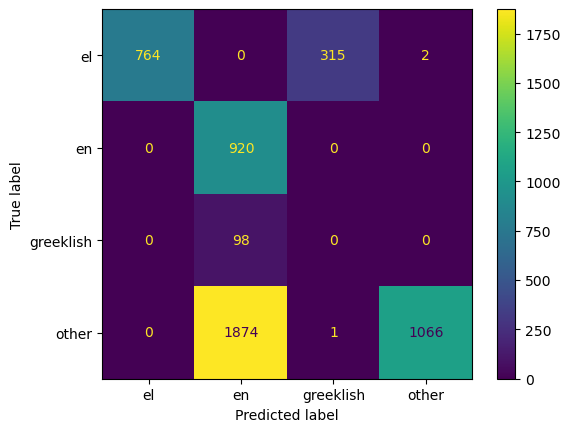

In [45]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Naive Bayes

https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba

In [46]:
from sklearn.naive_bayes import MultinomialNB


naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, naive_x_train, y_train, cv=5)
print(f"Naive Bayes mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes mean macro F1-score 0.7692, std: 0.7874


Macro F1: 0.8104697597941073
              precision    recall  f1-score   support

          el       0.99      0.98      0.98      1081
          en       0.96      1.00      0.98       920
   greeklish       1.00      0.17      0.30        98
       other       0.97      0.99      0.98      2941

    accuracy                           0.98      5040
   macro avg       0.98      0.79      0.81      5040
weighted avg       0.98      0.98      0.97      5040



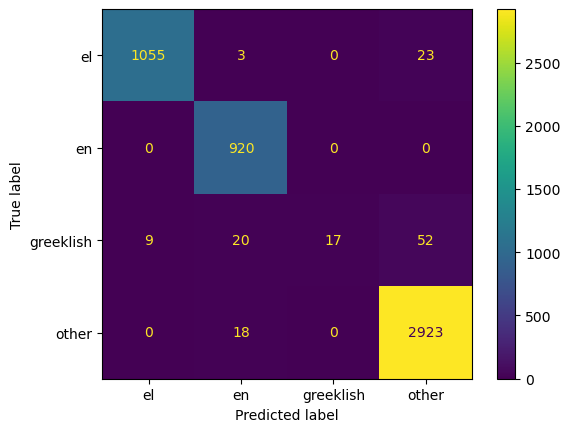

In [47]:
from sklearn.naive_bayes import MultinomialNB


naive_model = MultinomialNB().fit(naive_x_train, y_train)
naive_res = naive_model.predict(naive_x_test)

get_statistics(y_test, naive_res)

### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.8306, std: 0.8299


Macro F1: 0.8574896165852381
              precision    recall  f1-score   support

          el       1.00      0.92      0.96      1081
          en       0.98      0.97      0.98       920
   greeklish       1.00      0.36      0.53        98
       other       0.94      1.00      0.97      2941

    accuracy                           0.96      5040
   macro avg       0.98      0.81      0.86      5040
weighted avg       0.96      0.96      0.96      5040



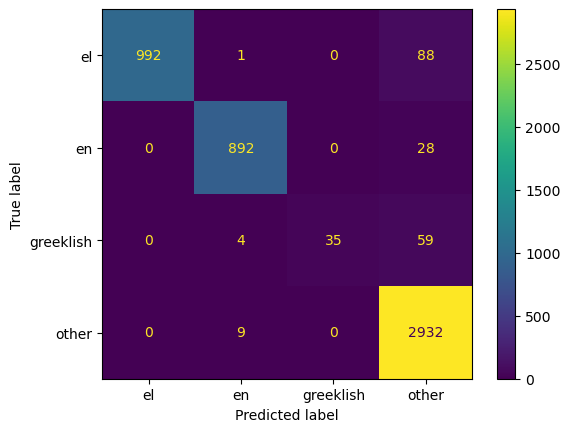

In [49]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

### Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Macro F1: 0.9202415562889347
              precision    recall  f1-score   support

          el       1.00      0.97      0.98      1081
          en       0.97      1.00      0.98       920
   greeklish       0.95      0.59      0.73        98
       other       0.98      0.99      0.99      2941

    accuracy                           0.98      5040
   macro avg       0.97      0.89      0.92      5040
weighted avg       0.98      0.98      0.98      5040



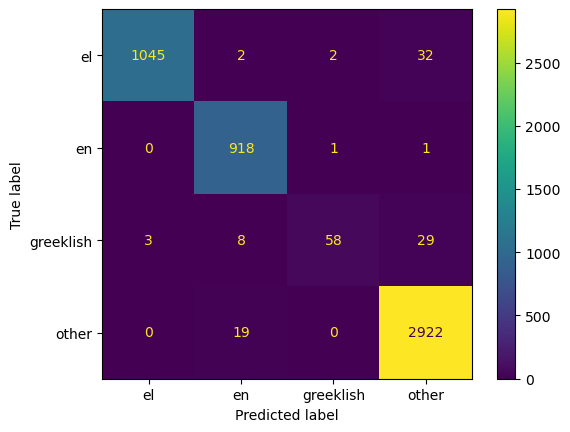

In [50]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

Macro F1: 0.8329390991715669
              precision    recall  f1-score   support

          el       0.99      0.87      0.93      1081
          en       0.98      0.95      0.97       920
   greeklish       0.77      0.35      0.48        98
       other       0.93      0.99      0.96      2941

    accuracy                           0.95      5040
   macro avg       0.92      0.79      0.83      5040
weighted avg       0.95      0.95      0.94      5040



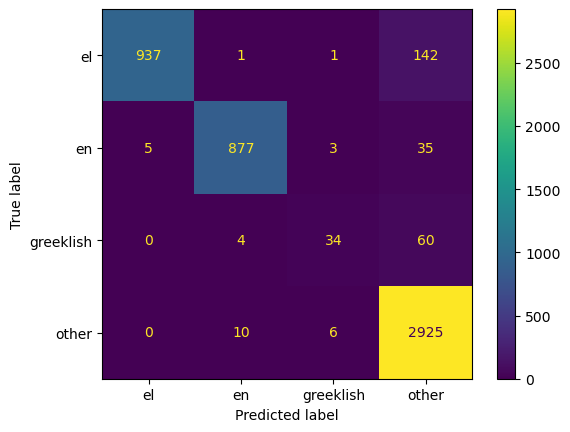

In [51]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [52]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
8826,other,en,No matter what I do all the Quick Connects fit...
296,other,greeklish,lol fail 3
714,other,el,Ήταν αφοσιωμένη σ ' αυτήν ! Εγώ .
2959390,other,greeklish,Bubblethesap Icecrown wotlk horde belf
504,other,el,500κ
...,...,...,...
3595,other,el,Πουαρό ! Έκλαψα .
7558,other,el,28 Σε ορισμένες περιπτώσεις απαιτούνται μεγαλύ...
334,other,el,κάνε league legends 3
4202,other,el,Υπάρχουν πιθανώς άπειροι πλανήτες .


In [53]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
2792275,other,greeklish,Meta to xtesino mas raid ICC25 exume 8/12hc ...
2823457,other,greeklish,kai ellhnes paixtes epishs na lvlaroume mazi
504,other,el,500κ
229,greeklish,el,Hayate army αχαχαχαχα
388,en,greeklish,Konohagakure Hiden Secret Taijutsu Technique: ...
...,...,...,...
1514,other,el,Θέλεις δουλειά ;
23542,en,other,Yeah inauma exactly inauma. i hate it
1444,other,el,"Τίποτα , κυρία κάβεντις ;"
11807,en,other,"Jab urban ne vietnam kai lye chora, hum thore ..."


### Hyperparameter tuning

In [54]:
estimators = []
scores = []

for n_estimators in tqdm([int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]):
    estim = RandomForestClassifier(n_estimators=n_estimators, 
                                  n_jobs=-1, 
                                  criterion="entropy").fit(x_train, y_train)
    score = f1_score(y_val, estim.predict(x_val), average='macro', zero_division=0)

    estimators.append(estim)
    scores.append(score)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:10<00:00, 110.17s/it]


In [55]:
best_model = estimators[np.argmax(scores)]
print(f"Best model {best_model} with macro F1 score of {max(scores)}")

Best model RandomForestClassifier(criterion='entropy', n_estimators=775, n_jobs=-1) with macro F1 score of 0.9335344196598307


### Annotating the operational dataset

In [56]:
x_oper = vectorizer.transform(crawl_df.text)
crawl_df["language"] = best_model.predict(x_oper)

In [57]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


### Exploring the operational dataset

In [58]:
crawl_df["language"] = best_model.predict(x_oper)

In [59]:
RESOURCE_OUTPUT = "results"

def save_plot(filename):
    path = os.path.join(RESOURCE_OUTPUT, filename)
    plt.savefig(path, bbox_inches="tight")
    print(f"Figured saved to " + path)

Figured saved to results\lang_dis.png


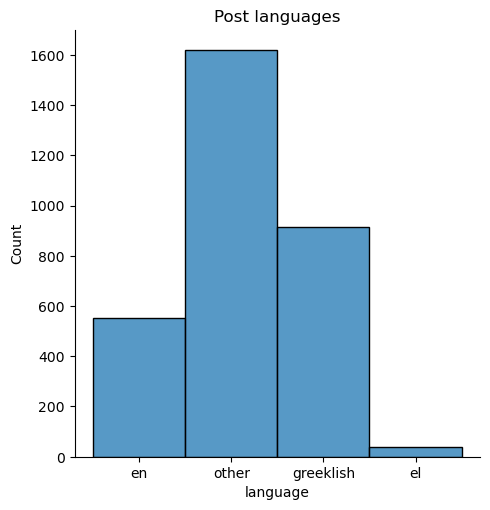

In [60]:
import seaborn as sns


sns.displot(crawl_df.language)
save_plot("lang_dis.png")
plt.title("Post languages")
plt.show()

In [61]:
languages = np.unique(crawl_df.language)

lang_col = []
len_col = []

for language in languages:
    if language != "other":
        comments_text = crawl_df.loc[crawl_df.language == language, "text"]
        comments_length = comments_text.apply(lambda x: len(x))
        
        lang_col += [language] * len(comments_length)
        len_col += list(comments_length)

len_df = pd.DataFrame({"language": lang_col, "comment_length": len_col})

In [62]:
palette ={"el": "blue", "en": "red", "greeklish": "green"}

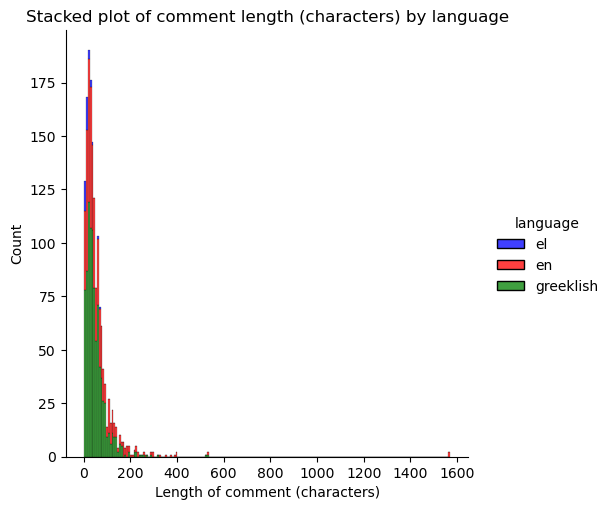

In [63]:
sns.displot(len_df, x="comment_length", hue="language", multiple="stack", palette=palette)
plt.title("Stacked plot of comment length (characters) by language")
plt.xlabel("Length of comment (characters)")
plt.show()

Figured saved to results\length_dis.png


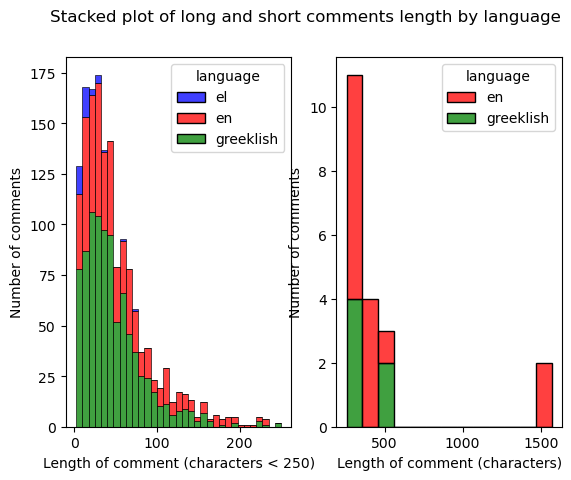

In [64]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(len_df[len_df.comment_length<=250],
             x="comment_length", 
             hue="language", 
             multiple="stack", 
             palette=palette,
             ax=ax1)
ax1.set_xlabel("Length of comment (characters < 250)")
ax1.set_ylabel("Number of comments")

sns.histplot(len_df[len_df.comment_length>250], 
             x="comment_length", 
             hue="language", 
             multiple="stack",
             palette=palette,
             ax=ax2)
ax2.set_xlabel("Length of comment (characters)")
ax2.set_ylabel("Number of comments")

fig.suptitle("Stacked plot of long and short comments length by language")
save_plot("length_dis.png")
plt.show()

In [65]:
len_df.iloc[np.argmax(len_df.comment_length)]

language            en
comment_length    1570
Name: 275, dtype: object

In [66]:
emoji_pattern = re.compile(
    r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF'
    r'\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF'
    r'\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\u2600-\u26FF\u2700-\u27BF'
    r'\u2B50\u2B06\u2934\u2935\u2B05\u2194-\u2199\u21A9\u21AA\u2139\u2328'
    r'\u23CF\u23E9-\u23F3\u231A\u23F8-\u23FA\u231B\u23F0\u231A\u1F004'
    r'\u1F0CF\u1F18E\u3030\u303D]'
)

emojis_col = []

for language in languages:
    if language != "other":
        comments_text = crawl_df.loc[crawl_df.language == language, "text"]
        comments_length = comments_text.apply(lambda x: len(emoji_pattern.findall(x)))
    
        emojis_col += list(comments_length)

emoji_df = pd.DataFrame({"language": lang_col, "emojis": emojis_col})

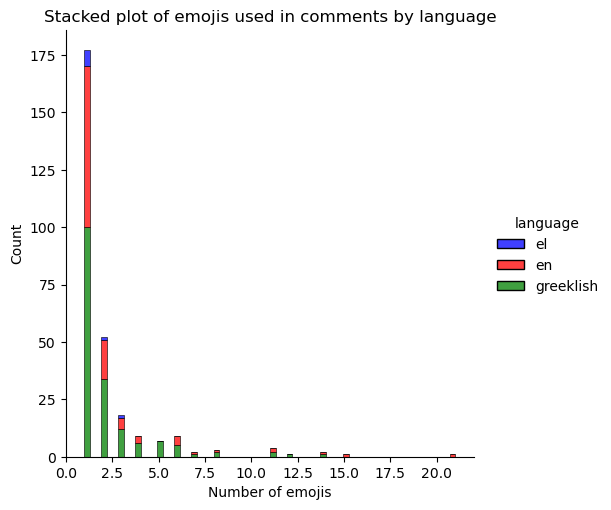

In [67]:
sns.displot(emoji_df[emoji_df.emojis > 0],
            x="emojis", 
            hue="language",
            multiple="stack",
            palette=palette)
plt.title("Stacked plot of emojis used in comments by language")
plt.xlabel("Number of emojis")
plt.show()

Figured saved to results\length_dis.png


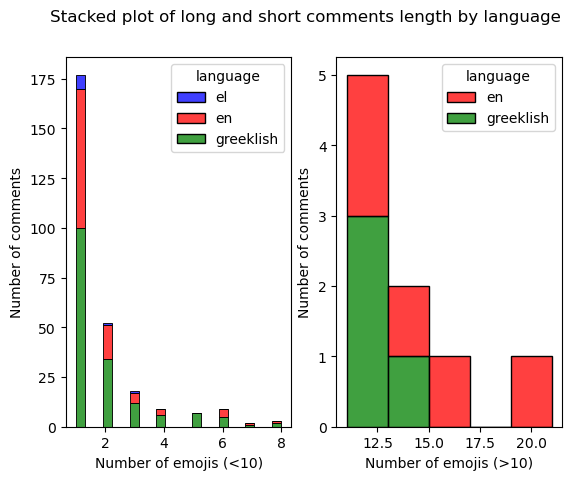

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(emoji_df[(emoji_df.emojis > 0) & (emoji_df.emojis < 10)],
             x="emojis",
             hue="language",
             multiple="stack",
             palette=palette,
             ax=ax1)
ax1.set_xlabel("Number of emojis (<10)")
ax1.set_ylabel("Number of comments")

sns.histplot(emoji_df[emoji_df.emojis > 10],
             x="emojis", 
             hue="language", 
             multiple="stack",
             palette=palette,
             ax=ax2)
ax2.set_xlabel("Number of emojis (>10)")
ax2.set_ylabel("Number of comments")

fig.suptitle("Stacked plot of long and short comments length by language")
save_plot("length_dis.png")
plt.show()

In [69]:
date_df = crawl_df.groupby(["date", "language"]).count()
date_df

Unnamed: 0  title  link  source  text
date       language                                        
2015-11-27 el                  1      1     1       1     1
           greeklish           3      3     3       3     3
           other               3      3     3       3     3
2016-11-27 en                  2      2     2       2     2
           other               1      1     1       1     1
...                          ...    ...   ...     ...   ...
2023-11-25 greeklish           3      3     3       3     3
           other               4      4     4       4     4
2023-11-26 en                  2      2     2       2     2
           other               8      8     8       8     8
2023-11-27 other               1      1     1       1     1

[108 rows x 5 columns]

In [70]:
date_df2 = date_df.reset_index()
date_df2.date = pd.to_datetime(date_df2.date)
date_df2.date

0     2015-11-27
1     2015-11-27
2     2015-11-27
3     2016-11-27
4     2016-11-27
         ...    
103   2023-11-25
104   2023-11-25
105   2023-11-26
106   2023-11-26
107   2023-11-27
Name: date, Length: 108, dtype: datetime64[ns]

Figured saved to results\time_plot.png


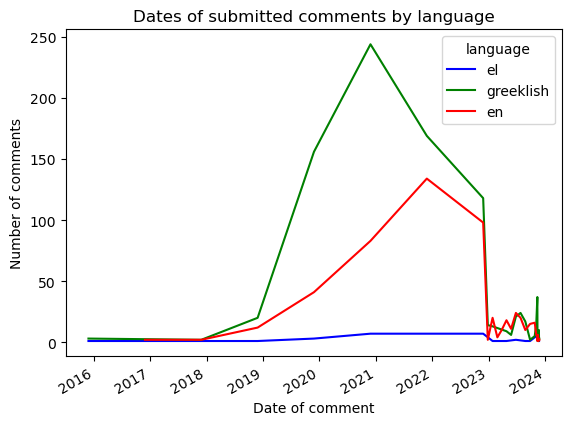

In [71]:
import matplotlib.dates as mdates


sns.lineplot(x="date", 
             y="text",
             hue="language", 
             palette=palette,
             data=date_df2[date_df2.language != "other"])

plt.title("Dates of submitted comments by language")
plt.xlabel("Date of comment")
plt.ylabel("Number of comments")

plt.gcf().autofmt_xdate()
plt.gca().fmt_xdata = mdates.DateFormatter('%Y-%m')

save_plot("time_plot.png")
plt.show()

## Toxicity Classification

### Importing the data

In [72]:
with open(os.path.join("data", "chatgpt_annot.txt"), "r", encoding="utf8") as file:
    raw_annot = file.read()

records = raw_annot.split("\n")
len(records), records[0]

(365,
 '"Εαν σας άρεσε κάντε Like ρεεε μη ντρέπεστε! +1 όσοι είδαν το μπλουζάκι PDT p.s το AR το βάλαμε έτσι για συντομογραφία, εννοείται πως άλλο AR και άλλο τρίσφαιρο!" - 1')

In [73]:
annotations = [record.split("-") for record in records]

comments = []
values = []
for annotation in filter(lambda x: len(x) != 1, annotations):
    comment = annotation[0]
    value = int(annotation[1])
    comments.append(comment)
    values.append(value)

comments[0], values[0]

('"Εαν σας άρεσε κάντε Like ρεεε μη ντρέπεστε! +1 όσοι είδαν το μπλουζάκι PDT p.s το AR το βάλαμε έτσι για συντομογραφία, εννοείται πως άλλο AR και άλλο τρίσφαιρο!" ',
 1)

In [74]:
toxicity_df = pd.DataFrame({"comments": comments, "toxicity": values})
toxicity_df

,comments,toxicity
0,"""Εαν σας άρεσε κάντε Like ρεεε μη ντρέπεστε! +...",1
1,"""Φήμες λένε ότι ο Gianuba βάζει καρδούλες ️""",1
2,"""Congrats on your channel , que venha o 1 milh...",1
3,"""ΤΟΣΑ ΤΕΛΕΙΑ ΒΙΝΤΕΟ ΘΑ ΚΑΝΕΙ Ο GIANOUBA22""",1
4,"""Η φάση που ο gianuba 22 φοράει μπλούζα pdt nu...",1
...,...,...
178,"Ψάχνουμε άτομα για raid Παρασκευή 9:00, Σάββατ...",3
179,Μήπως παίζατε καθόλου στον παλιό Neltharion πρ...,4
180,Σε Horde ή Alliance θα είναι το guild;,1
181,Υπάρχει κανένα active ελληνικό guild από πλευρ...,1


In [75]:
np.unique(toxicity_df.toxicity)

array([1, 2, 3, 4, 5], dtype=int64)

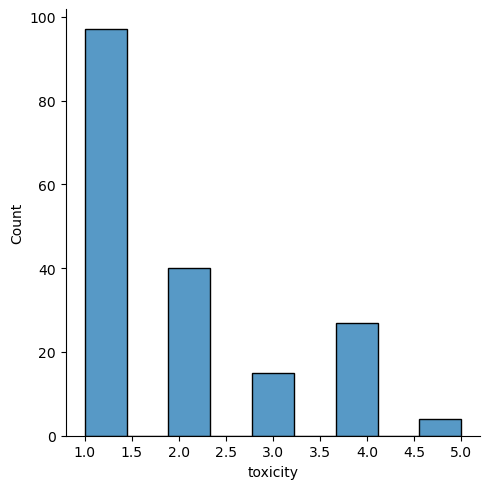

In [76]:
sns.displot(toxicity_df.toxicity)

### Data Transformation

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(toxicity_df, random_state=42)
vectorizer = TfidfVectorizer().fit(data_train.comments)
x_train = vectorizer.transform(data_train.comments)
y_train = data_train.toxicity
x_test = vectorizer.transform(data_test.comments)
y_test = data_test.toxicity

### Model Selection

### Naive Bayes

https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba

In [78]:
naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, naive_x_train, y_train, cv=5)
print(f"Naive Bayes mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes mean macro F1-score 0.2797, std: 0.1395


C:\Users\user\anaconda3\envs\manis\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Macro F1: 0.21913043478260869
              precision    recall  f1-score   support

           1       0.55      0.96      0.70        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         4
           4       0.50      0.33      0.40         3
           5       0.00      0.00      0.00         1

    accuracy                           0.54        46
   macro avg       0.21      0.26      0.22        46
weighted avg       0.33      0.54      0.40        46



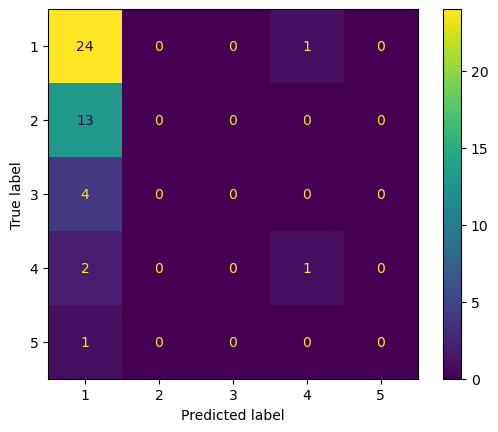

In [79]:
naive_model = MultinomialNB().fit(naive_x_train, y_train)
naive_res = naive_model.predict(naive_x_test)

get_statistics(y_test, naive_res)

### Logistic Regression

In [80]:
with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.1818, std: 0.4605


Macro F1: 0.21913043478260869
              precision    recall  f1-score   support

           1       0.55      0.96      0.70        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         4
           4       0.50      0.33      0.40         3
           5       0.00      0.00      0.00         1

    accuracy                           0.54        46
   macro avg       0.21      0.26      0.22        46
weighted avg       0.33      0.54      0.40        46



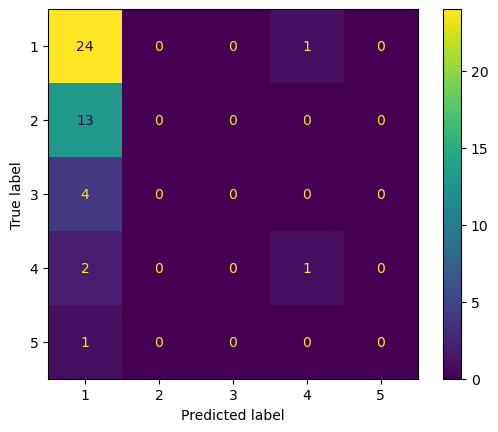

In [81]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

### Random Forest

In [82]:
forest_model = RandomForestClassifier(n_estimators=50, 
                                      n_jobs=-1, 
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

C:\Users\user\anaconda3\envs\manis\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


Random Forest mean macro F1: 0.3092, std: 0.4472


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Macro F1: 0.2173134328358209
              precision    recall  f1-score   support

           1       0.55      0.92      0.69        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         4
           4       0.50      0.33      0.40         3
           5       0.00      0.00      0.00         1

    accuracy                           0.52        46
   macro avg       0.21      0.25      0.22        46
weighted avg       0.33      0.52      0.40        46



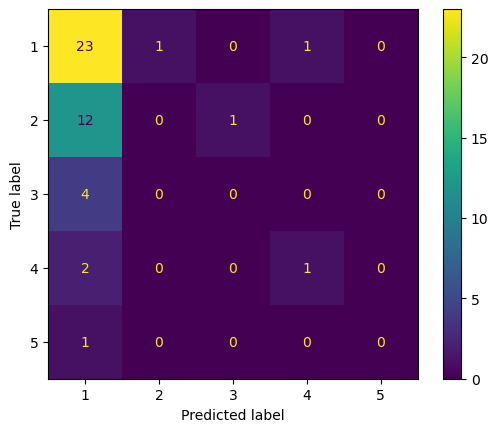

In [95]:
forest_model = RandomForestClassifier(n_estimators=100,
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

In [84]:
ada_model = AdaBoostClassifier(n_estimators=50)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.2347, std: 0.2274


Macro F1: 0.24285714285714288
              precision    recall  f1-score   support

           1       0.56      1.00      0.71        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         4
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         1

    accuracy                           0.57        46
   macro avg       0.31      0.27      0.24        46
weighted avg       0.37      0.57      0.42        46



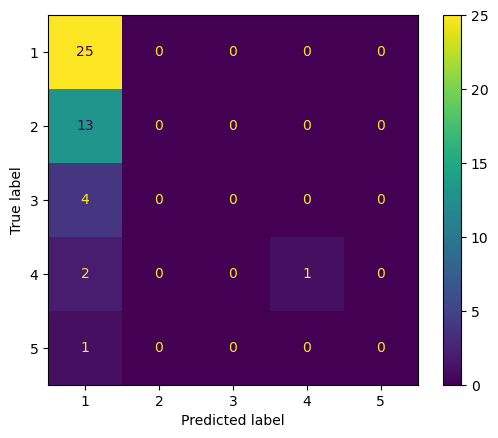

In [85]:
ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

### Classifiying the crawled data

In [97]:
crawl_df["toxicity"] = ada_model.predict(vectorizer.transform(crawl_df.text))
crawl_df

,Unnamed: 0,title,link,source,text,date,language,toxicity
0,0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,"Great selection, one more time. THANKS!",2023-07-27,en,1
3,3,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,song,️,2023-07-27,other,1
4,4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Încă o zi petrecută cu muzica voastră fantas...,2022-11-27,other,1
5,5,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,ANTIGUAS CANCIONES DE GRECIA PAIS NATAL DE MIS...,2022-11-27,other,1
6,6,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,FelicităriSuperb \nSă fiți mereu bine \nMomen...,2022-11-27,other,1
...,...,...,...,...,...,...,...,...
3450,3450,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,Fake,2023-11-18,other,1
3451,3451,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,malaka einai gia ton poutso to stisimo tou vinteo,2023-11-23,greeklish,1
3452,3452,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,KALITERA,2023-11-19,other,1
3453,3453,Θα Χωρίσω Εξαιτίας Του Fortnite…,https://www.youtube.com/watch?v=jla9IrQAIkk&pp...,gaming,o monos youtuber pou dn exei bgalei pote fake ...,2023-11-18,greeklish,1


### Analysing the Toxicity of crawled data

#### Finding the most toxic language

In [103]:
crawl_df.loc[:, ["language", "toxicity"]].groupby("language").mean()

,toxicity
language,
el,1.000000
en,1.090744
greeklish,1.009847
other,1.000000


#### Finding the most toxic video

In [118]:
toxic_videos_df = crawl_df.loc[:, ["link", "toxicity"]].groupby("link").mean().sort_values("toxicity", ascending=False)
toxic_videos_df

,toxicity
link,
https://www.youtube.com/watch?v=dyZXS49yhcU&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.333333
https://www.youtube.com/watch?v=_fnNiMXH4PI&pp=ygUOZ3JlZWsgZm9ydG5pdGU%3D,1.214286
https://www.youtube.com/watch?v=z4DMFzyCkP0&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.136364
https://www.youtube.com/watch?v=-hsjov_72W0&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.133333
https://www.youtube.com/watch?v=ii2To2gvzkU&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.121951
...,...
https://www.youtube.com/watch?v=JA_8z_JGQnU&pp=ygUOZ3JlZWsgZm9ydG5pdGU%3D,1.000000
https://www.youtube.com/watch?v=IosIQt6716w&pp=ygUOZ3JlZWsgZm9ydG5pdGU%3D,1.000000
https://www.youtube.com/watch?v=I_I5RympRL4&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.000000


In [123]:
toxic_videos_df.merge(crawl_df.loc[:, ["link", "title"]].drop_duplicates(), 
                      on="link", 
                      how="inner").loc[:, ["title", "link", "toxicity"]]

,title,link,toxicity
0,Ρομαντικά Ελαφρά Τραγούδια | Non Stop Mix,https://www.youtube.com/watch?v=dyZXS49yhcU&pp...,1.333333
1,ΞΕΚΛΕΙΔΩΣΑ ΟΛΟ ΤΟ BATTLE PASS ΤΗΣ SEASON 2! (F...,https://www.youtube.com/watch?v=_fnNiMXH4PI&pp...,1.214286
2,Ελαφρολαϊκά παλιά - 120 μεγάλες επιτυχίες (by ...,https://www.youtube.com/watch?v=z4DMFzyCkP0&pp...,1.136364
3,Nina Mazani - Άγχος (Από το “Ενκάντο: Ένας Κόσ...,https://www.youtube.com/watch?v=-hsjov_72W0&pp...,1.133333
4,Ένα τραγούδι η ζωή μας - 70 αγαπημένα τραγούδι...,https://www.youtube.com/watch?v=ii2To2gvzkU&pp...,1.121951
...,...,...,...
121,😱Παίζω DUO Με Τον ΞΑΔΕΡΦΟ ΜΟΥ(Fortnite GR)😱,https://www.youtube.com/watch?v=JA_8z_JGQnU&pp...,1.000000
122,Η Γιαγιά μου Αντιδρά - FORTNITE,https://www.youtube.com/watch?v=IosIQt6716w&pp...,1.000000
123,Greek Music Mix 2022 - Ελληνικα Τραγουδια Mix ...,https://www.youtube.com/watch?v=I_I5RympRL4&pp...,1.000000
124,Josephine - Μπερδέματα - Official Music Video,https://www.youtube.com/watch?v=HP26OIbNhX0&pp...,1.000000


#### Finding videos where toxicity was uniform across time

In [127]:
toxic_time_df = crawl_df.loc[:, ["link", "date", "toxicity"]].groupby(["link", "date"]).mean()
toxic_time_df

toxicity
link                                               date                
https://www.youtube.com/watch?v=-HrCOFXMUx8&pp=... 2023-01-27       1.0
                                                   2023-03-27       1.0
                                                   2023-09-27       1.0
                                                   2023-10-27       1.0
                                                   2023-11-20       1.0
...                                                                 ...
https://www.youtube.com/watch?v=z4DMFzyCkP0&pp=... 2020-11-27       1.0
                                                   2021-11-27       1.0
                                                   2022-11-27       1.3
                                                   2023-01-27       1.0
                                                   2023-06-27       1.0

[414 rows x 1 columns]

In [143]:
toxic_time_var_df = toxic_time_df.groupby(["link", "toxicity"]).std().reset_index().sort_values("toxicity", ascending=True)
uniform_toxic_df = toxic_time_var_df[toxic_time_var_df.toxicity == 1]
uniform_toxic_df.merge(crawl_df.loc[:, ["link", "title"]].drop_duplicates(), 
                      on="link", 
                      how="inner").loc[:, ["title", "link", "toxicity"]]

,title,link,toxicity
0,ΤΑ ΣΠΑΜΕ ΕΛΛΗΝΙΚΑ | KONSTANTINOS SOT,https://www.youtube.com/watch?v=-HrCOFXMUx8&pp...,1.0
1,♫ 5 Ωρες Non Stop special!! 💓🎵 Αποκλειστικά γι...,https://www.youtube.com/watch?v=gUeMZez8GzU&pp...,1.0
2,Ελληνικό Έντεχνο - Eλαφρολαϊκό mix,https://www.youtube.com/watch?v=gR7_-sfui2Q&pp...,1.0
3,ΠΡΟΚΑΛΕΣΑ STREAMSNIPER ΣΕ 1V1?! ΔΕΙΤΕ ΤΙ ΕΓΙΝΕ..,https://www.youtube.com/watch?v=g7bRk9vuK58&pp...,1.0
4,ΤΡΟΛΛΑΡΩ ΚΙΝΕΖΟΥΣ ΣΤΟ FORTNITE! (Fortnite Greek),https://www.youtube.com/watch?v=g55k5_chwn0&pp...,1.0
...,...,...,...
121,WINS ΜΟΝΟ ΜΕ SKYBASE ΣΤΟ NEW SEASON! (Fortnite...,https://www.youtube.com/watch?v=Ftj64tji0ao&pp...,1.0
122,"ΞΕΧΑΣΤΕ ΤΟ FORTNITE, ΑΛΛΑΖΟΥΝ ΟΛΑ... ΜΙΑ ΝΕΑ Α...",https://www.youtube.com/watch?v=Fn2p7UfGvzY&pp...,1.0
123,ΠΑΜΕ ΓΙΑ ΡΕΚΟΡ ΣΤΟ FORTNITE ONLY UP CHAPTER 2 ...,https://www.youtube.com/watch?v=v07kK2gKAiE&pp...,1.0
124,ΜΕ SCAMMARE ΚΟΡΙΤΣΙ🤭😂(SCAMMER GETS SCAMMED){GR...,https://www.youtube.com/watch?v=ExbSJygJtTE&pp...,1.0


#### Finding videos where toxicity increases over time

In [165]:
toxic_time_incr_df = crawl_df.loc[:,["link", "date", "toxicity"]].copy()
toxic_time_incr_df = toxic_time_incr_df.sort_values("date")
toxic_time_incr_df["toxicity_diff"] = toxic_time_incr_df.toxicity.diff()
toxic_time_incr_df = toxic_time_incr_df.loc[toxic_time_incr_df.toxicity_diff > 0, :]
toxic_time_incr_df = toxic_time_incr_df.loc[:, ["link", "toxicity_diff"]].groupby("link").mean()
toxic_time_incr_df = toxic_time_incr_df.reset_index().sort_values("toxicity_diff", ascending=False)
toxic_time_incr_df

,link,toxicity_diff
1,https://www.youtube.com/watch?v=0sTegFKn-nQ&pp...,3.0
4,https://www.youtube.com/watch?v=ExbSJygJtTE&pp...,3.0
5,https://www.youtube.com/watch?v=KTLpcbiqFFs&pp...,3.0
6,https://www.youtube.com/watch?v=ZTJPZJ453dY&pp...,3.0
7,https://www.youtube.com/watch?v=_fnNiMXH4PI&pp...,3.0
8,https://www.youtube.com/watch?v=b-GnJoG6VE8&pp...,3.0
14,https://www.youtube.com/watch?v=rJabqwE75Ig&pp...,3.0
15,https://www.youtube.com/watch?v=z4DMFzyCkP0&pp...,3.0
10,https://www.youtube.com/watch?v=gUeMZez8GzU&pp...,2.6
11,https://www.youtube.com/watch?v=ii2To2gvzkU&pp...,2.5


In [88]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 20 minutes and 59.0 seconds
